In [1]:
import os
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!dir

 Volume in drive D is New Volume
 Volume Serial Number is DC85-82A4

 Directory of D:\Github\DanhgiaDuAnVaNghenghiepTuongLai\code_ai\TestCode_ver5

06/26/2024  04:57 PM    <DIR>          .
06/26/2024  02:57 PM    <DIR>          ..
06/26/2024  04:12 PM    <DIR>          .idea
06/26/2024  04:30 PM                30 config.txt
06/26/2024  04:11 PM           219,236 RunCode - Copy.ipynb
06/26/2024  04:57 PM            20,127 RunCode.ipynb
06/26/2024  04:30 PM            18,488 uncategorized_projects.csv
               4 File(s)        257,881 bytes
               3 Dir(s)  109,412,462,592 bytes free


In [3]:
# Xóa file mô hình cũ nếu tồn tại
if os.path.exists('best_model.keras'):
    os.remove('best_model.keras')
    os.remove('categories.joblib')
    os.remove('tokenizer.joblib')
    os.remove('uncategorized_projects.csv')

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Hàm xây dựng mô hình tối ưu
def build_model(vocab_size, num_classes, input_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length),
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.5),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Sử dụng activation 'sigmoid' cho phân loại đa nhãn
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
# Hàm vẽ biểu đồ
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Biểu đồ Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Biểu đồ Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
# Tạo từ điển ánh xạ với nhóm từ khóa cho mỗi chủ đề
technically = {
    'website': ['website', 'web'],
    'mobile-app': ['mobile app', 'app di động', 'Xây dựng ứng dụng', 'Xây dựng Ứng dụng', 'Ứng dụng di động', 'Phát triển ứng dụng', 'Xây dựng ứng dụng', 'hệ thống nhận diện'],
    'game': ['game', 'trò chơi'],
    'chatbot': ['chatbot', 'chat bot'],
    'artificial-intelligence': ['trí tuệ nhân tạo', 'Yolo', 'AIOT'],
    'machine-learning': ['machine learning', 'máy học'],
    'deep-learning': ['deep learning', 'học sâu'],
    'computer-vision': ['computer vision', 'thị giác máy tính'],
    'big-data': ['big data', 'dữ liệu lớn', 'bigdata'],
    'data-analysis': ['data analysis', 'phân tích dữ liệu'],
    'cloud-computing': ['cloud computing', 'điện toán đám mây', 'K8s', 'kubernetes'],
    'blockchain': ['blockchain', 'chuỗi khối', 'NFT'],
    'robot': ['robot', 'robotics', 'robotic'],
    'drone': ['drone', 'flycam'],
    'vr': ['vr', 'thực tế ảo', 'virtual reality'],
    'iot': ['nhà thông minh', 'thiết bị thông minh', 'AIOT', 'iot', 'ESP32', 'MQTT', 'vườn thông minh'],
}

In [8]:
# Tải dữ liệu
pd_data = pd.read_csv('D:/Github/DanhgiaDuAnVaNghenghiepTuongLai/dataset/dataset_train_ver1.csv')
pd_data

,STT,nameProject_VNI,nameProject_ENG,course,difficulty_level,codeSememter,major,specialization,university,note
0,1.0,Xây dựng hệ thống quản lý sân cầu lông,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
1,2.0,Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
2,3.0,Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
3,4.0,Xây dựng mạng xã hội kết hợp chatbot cho người...,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
4,5.0,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
...,...,...,...,...,...,...,...,...,...,...
854,NaN,Ứng dụng Blockchain trong quản lý hệ thống chă...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
855,NaN,Phát triển hệ thống quản lý thông tin bảo hiểm...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,NaN,Ứng dụng Blockchain trong quản lý dịch vụ hưu ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857,NaN,Blockchain và bảo mật trong dịch vụ bảo mật th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_train = pd_data[['nameProject_VNI']].copy()

# Đếm số lần xuất hiện của mỗi tên dự án
project_counts = df_train['nameProject_VNI'].value_counts()
# Hiển thị các tên dự án có số lần xuất hiện nhiều hơn 1
duplicate_projects = project_counts[project_counts > 1]
print(duplicate_projects)

nameProject_VNI
Nghiên cứu và thử nghiệm một số phương pháp định giá BĐS                                                                          4
Tìm hiểu Thị giác máy tính vận dụng trong phát triển ứng dụng Game 3D tương tác, Thực thể ảo AR.                                  3
Phát triển ứng dụng phân tích dữ liệu y khoa trong xét nghiệm máu                                                                 3
Hệ thống nhà thông minh                                                                                                           3
Nhà thông minh                                                                                                                    2
Ứng dụng Trí Tuệ Nhận Diện Khuôn Mặt                                                                                              2
Ứng dụng MQTT trong nhà thông minh                                                                                                2
Ứng dụng trí tuệ nhân tạo phát hiện và phân loại khối u não 

In [10]:
# Lọc và hiển thị các bản ghi có tên dự án trùng lặp
duplicates = df_train[df_train['nameProject_VNI'].isin(duplicate_projects.index)]
# print(duplicates)

# Loại bỏ các trùng lặp, chỉ giữ lại bản ghi đầu tiên
df = df_train.drop_duplicates(subset=['nameProject_VNI'], keep='first')

In [11]:
# Đếm số lần xuất hiện của mỗi tên dự án
project_counts = df['nameProject_VNI'].value_counts()
# Hiển thị các tên dự án có số lần xuất hiện nhiều hơn 1
duplicate_projects = project_counts[project_counts > 1]
print(duplicate_projects)

Series([], Name: count, dtype: int64)


In [12]:
# df['category'] = df['nameProject_VNI'].apply(categorize_project)
# # pd_data
print(df)

                                       nameProject_VNI
0               Xây dựng hệ thống quản lý sân cầu lông
1    Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...
2    Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...
3    Xây dựng mạng xã hội kết hợp chatbot cho người...
4    Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...
..                                                 ...
853  Blockchain và bảo mật trong dịch vụ tư vấn tài...
854  Ứng dụng Blockchain trong quản lý hệ thống chă...
855  Phát triển hệ thống quản lý thông tin bảo hiểm...
856  Ứng dụng Blockchain trong quản lý dịch vụ hưu ...
857  Blockchain và bảo mật trong dịch vụ bảo mật th...

[801 rows x 1 columns]


In [13]:
# Hàm phân loại chủ đề
def categorize_project(project_name):
    matched_themes = []
    for theme, keywords in technically.items():
        if any(keyword.lower() in project_name.lower() for keyword in keywords):
            matched_themes.append(theme)
    return ', '.join(matched_themes) if matched_themes else None

# Assuming df is your DataFrame and it's already defined
# Make sure to directly modify the 'category' column in a safe manner
df.loc[:, 'category'] = df['nameProject_VNI'].apply(lambda x: categorize_project(x) if categorize_project(x) else '')

# Tìm các hàng không có category được phân loại và lưu vào một file CSV mới
uncategorized_df = df[df['category'] == '']
uncategorized_df.to_csv('uncategorized_projects.csv', index=False, encoding='utf-8')

# Hiển thị các hàng không có category được phân loại
print("Các hàng không có category được phân loại:")
print(df[df['category'] == ''])

# Loại bỏ các hàng không có category được phân loại
df = df[df['category'] != '']

# Hiển thị DataFrame đã cập nhật
print("\nDataFrame sau khi loại bỏ các hàng không có category được phân loại:")
print(df)

Các hàng không có category được phân loại:
                                       nameProject_VNI category
0               Xây dựng hệ thống quản lý sân cầu lông         
2    Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...         
6    Nghiên cứu và thử nghiệm một số phương pháp đị...         
8    Xây dựng hệ thống quản lý phòng trọ và gợi ý c...         
10   Xây dựng Shop quần áo online tích hợp gợi ý sả...         
..                                                 ...      ...
728    Phát hiện bệnh trên lá của cây cà chua bằng CNN         
740               Ứng dụng Trí Tuệ Nhận Diện Khuôn Mặt         
742               Ứng dụng phát hiện ung thư đại tràng         
743  Nhận diện bàn tay đoán ra kí tự người khuyết t...         
762   Hợp đồng thông minh cho hệ thống bầu cử điện tử.         

[263 rows x 2 columns]

DataFrame sau khi loại bỏ các hàng không có category được phân loại:
                                       nameProject_VNI             category
1    Tìm hiểu công 

C:\Users\huuth\AppData\Local\Temp\ipykernel_1820\2065964452.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'category'] = df['nameProject_VNI'].apply(lambda x: categorize_project(x) if categorize_project(x) else '')


<Axes: xlabel='count', ylabel='university'>

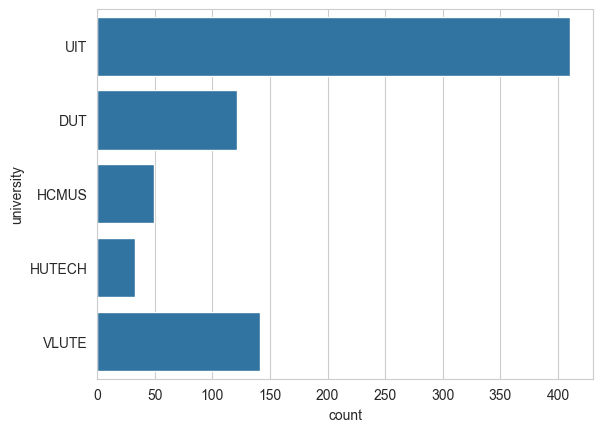

In [14]:
# UIT: Đại học Công nghệ thông tin HCM
# DUT: Đại học Đại học Bách Khoa - Đại học Đà Nẵng
# HCMUS: Đại học Khoa học Tự nhiên - Đại học Quốc gia TP.HCM
import seaborn as sns
sns.countplot(pd_data['university'])

In [15]:
# Số lượng đồ án của từng trường ĐH
pd_data['university'].value_counts()

university
UIT       410
VLUTE     141
DUT       121
HCMUS      49
HUTECH     33
Name: count, dtype: int64

In [16]:
# Tạo các cột chỉ báo cho mỗi chủ đề
category_dummies = pd.get_dummies(df['category'].apply(lambda x: x.split(', ')).explode()).groupby(level=0).sum()
df = pd.concat([df, category_dummies], axis=1)
df

,nameProject_VNI,category,artificial-intelligence,big-data,blockchain,chatbot,cloud-computing,computer-vision,data-analysis,deep-learning,drone,game,iot,machine-learning,mobile-app,robot,website
1,Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...,website,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Xây dựng mạng xã hội kết hợp chatbot cho người...,chatbot,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,"mobile-app, chatbot",0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
5,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,"mobile-app, chatbot",0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
7,Phân tích xu hướng bất động sản bằng Machine L...,machine-learning,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,Blockchain và bảo mật trong dịch vụ tư vấn tài...,blockchain,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
854,Ứng dụng Blockchain trong quản lý hệ thống chă...,blockchain,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
855,Phát triển hệ thống quản lý thông tin bảo hiểm...,blockchain,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
856,Ứng dụng Blockchain trong quản lý dịch vụ hưu ...,blockchain,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Lấy văn bản dự án và các nhãn
texts = df['nameProject_VNI'].values
categories = df.columns.difference(['nameProject_VNI', 'category'])
labels = df[categories].values

In [18]:
texts

array(['Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0 vào thực tiễn',
       'Xây dựng mạng xã hội kết hợp chatbot cho người nuôi thú cưng',
       'Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ tư vấn thuê bất động sản',
       'Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ tư vấn mua bán bất động sản',
       'Phân tích xu hướng bất động sản bằng Machine Learning kết hợp lịch sử giá và tin tức',
       'Xây dựng Ứng dụng đi chợ trực tuyến tích hợp gợi ý món ăn',
       'Xây dựng Ứng dụng nghe nhạc và gợi ý bài hát',
       'Tìm hiểu và phát triển ứng dụng giúp việc và cho thuê với Flutter',
       'Nghiên cứu công nghệ livestream và xây dựng ứng dụng minh hoạ',
       'Nghiên cứu công nghệ blockchain và ứng dụng vào game',
       'Nghiên cứu các kĩ thuật đồng thuận trong blockchain',
       'Nghiên cứu blockchain bridge và ứng dụng',
       'Xây dựng ứng dụng Web DeFi trên Blockchain',
       'Xây dựng ứng dụng hỗ trợ học tiếng anh trên thiết bị di động có áp dụng mô hình trí tuệ nhân

In [19]:
categories

Index(['artificial-intelligence', 'big-data', 'blockchain', 'chatbot',
       'cloud-computing', 'computer-vision', 'data-analysis', 'deep-learning',
       'drone', 'game', 'iot', 'machine-learning', 'mobile-app', 'robot',
       'website'],
      dtype='object')

In [20]:
print(labels)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [21]:
# # Chuẩn bị tokenizer và padding
# num_words = 10000
# tokenizer = Tokenizer(num_words=num_words)
# tokenizer.fit_on_texts(texts)
# # Chuyển đổi văn bản thành chuỗi số
# sequences = tokenizer.texts_to_sequences(texts)
# max_length = max(len(seq) for seq in sequences)
# data = pad_sequences(sequences, maxlen=max_length)
# 
# # Lưu các thông tin vào file txt
# with open('config.txt', 'w') as file:
#     file.write(f'MaxLength:{max_length}\n')
#     file.write(f'NumWords:{num_words}\n')

In [22]:
# Chia dữ liệu thành huấn luyện và thử nghiệm
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

NameError: name 'data' is not defined

In [ ]:
num_classes = y_train.shape[1]  # Đảm bảo num_classes bằng với kích thước thứ hai của y_train

# # Khởi tạo mô hình
# model = build_model(vocab_size=10000, num_classes=num_classes, input_length=max_length)

In [ ]:
print("Số lượng nhãn (num_classes):", num_classes)
print("Shape của y_train:", y_train.shape)
print("Shape của y_test:", y_test.shape)

In [ ]:
# Early stopping và checkpoint
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
num_rows = X_train.shape[0]
print(f"Số lượng hàng trong dữ liệu train là {num_rows}")
batch_size_options = [16, 32, 64]  # Các lựa chọn thử nghiệm

# Chọn batch size dựa trên hiệu suất của mô hình
batch_size = min(batch_size_options, key=lambda x: abs(x - num_rows//x * x))

print(f"Batch size được chọn: {batch_size}")

In [ ]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# import tensorflow as tf
# 
# # Tải tokenizer và mô hình đã được đào tạo sẵn
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
# 
# # Biên dịch mô hình
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# 
# # Chuẩn bị dữ liệu
# texts = data.tolist()  # Thay thế `data` bằng danh sách các văn bản thực tế của bạn
# labels = labels  # Thay thế `labels` bằng danh sách các nhãn đa nhãn thực tế của bạn
# inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=128)
# 
# # Huấn luyện mô hình
# history = model.fit(inputs['input_ids'], labels, epochs=3, batch_size=8)

In [ ]:
texts = texts.tolist()

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import create_optimizer
import tensorflow as tf
import numpy as np

# Tải tokenizer và mô hình đã được đào tạo sẵn
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=num_classes)

# Chuẩn bị dữ liệu
inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=128)
labels = tf.constant(labels)  # Chuyển đổi nhãn thành tensor

# Chuyển đổi dữ liệu thành Dataset của TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), labels)).shuffle(100).batch(8)

# Tạo optimizer
num_train_steps = len(dataset) * 3  # epochs = 3
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0,
)

# Biên dịch mô hình
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(dataset, epochs=3)

# Để làm sạch log, bạn có thể thêm đoạn mã sau:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Hàm predict
def predict(text, threshold=0.5):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True, max_length=128)
    predictions = model(inputs['input_ids'])
    logits = predictions.logits
    predicted_probabilities = tf.sigmoid(logits)
    predicted_labels = predicted_probabilities.numpy() > threshold
    predicted_categories = [categories[i] for i in range(len(categories)) if predicted_labels[0][i]]
    return predicted_categories

# Ví dụ sử dụng hàm predict
# sample_text = "Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0 vào thực tiễn"
# sample_text = "Lập trình ứng dụng bán gà ráng"
sample_text = "Nhận diện khuôn mặt bằng công nghệ trí tuệ nhân tạo sử dụng yolo"
predicted_categories = predict(sample_text)
print(predicted_categories)